# Rozpoznawanie gestów z akcelerometru – CNN-LSTM

In [4]:
!pip install torch torchvision torchaudio --quiet
!pip install scikit-learn seaborn --quiet

In [5]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Sprawdzenie dostępności GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Urządzenie treningowe: {device}')


Urządzenie treningowe: cuda


In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
import zipfile
from pathlib import Path

zip_path = '/content/drive/MyDrive/Colab Notebooks/data_ADXL345.zip'
image_path = ""

with zipfile.ZipFile(zip_path, "r") as zip_ref:
        print("Unzipping data...")
        zip_ref.extractall(image_path)

Unzipping data...


In [8]:
# 4. Parametry i lista gestów
DATA_FOLDER = '/content/data'
GESTURES = [
    "przesuniecie_w_prawo", "przesuniecie_w_lewo",
    "przesuniecie_w_gore", "przesuniecie_w_dol",
    "okrag_zgodnie_z_ruchem_wskazowek", "okrag_przeciwnie_do_ruchu_wskazowek",
    "litera_Z", "litera_V"
]
SEQUENCE_LENGTH = 80
OVERLAP_RATIO = 0.9
BATCH_SIZE = 32
LR = 1e-3
EPOCHS = 50


In [9]:
# 5. Przygotowanie Dataset
class GestureDataset(Dataset):
    def __init__(self, sequences, labels):
        self.X = torch.FloatTensor(sequences)
        self.y = torch.LongTensor(labels)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


In [10]:
# 6. Definicja modelu CNN-LSTM
class CNN_LSTM(nn.Module):
    def __init__(self, in_channels=3, hidden_size=64, n_classes=len(GESTURES)):
        super().__init__()
        # CNN
        self.conv1 = nn.Conv1d(in_channels, 32, kernel_size=3, padding=1)
        self.bn1   = nn.BatchNorm1d(32)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=3, padding=1)
        self.bn2   = nn.BatchNorm1d(64)
        self.pool  = nn.MaxPool1d(2)
        # LSTM
        self.lstm  = nn.LSTM(64, hidden_size, batch_first=True, dropout=0.2)
        # FC
        self.fc1   = nn.Linear(hidden_size, 32)
        self.dropout = nn.Dropout(0.3)
        self.fc2   = nn.Linear(32, n_classes)
        self.relu  = nn.ReLU()
    def forward(self, x):
        # x: (batch, seq_len, features) -> (batch, features, seq_len)
        x = x.transpose(1,2)
        x = self.pool(self.relu(self.bn1(self.conv1(x))))
        x = self.pool(self.relu(self.bn2(self.conv2(x))))
        # (batch, features, seq) -> (batch, seq, features)
        x = x.transpose(1,2)
        # LSTM
        out, _ = self.lstm(x)
        last = out[:,-1,:]                  # ostatni krok
        x = self.relu(self.fc1(last))
        x = self.dropout(x)
        return self.fc2(x)


In [11]:
# 7. Funkcja ładowania i tworzenia sekwencji
def load_sequences(folder):
    scaler = StandardScaler()
    seqs, labs = [], []
    for idx, label in enumerate(GESTURES):
        files = [f for f in os.listdir(folder) if f.startswith(label) and f.endswith('.csv')]
        for fn in files:
            df = pd.read_csv(os.path.join(folder, fn))
            arr = df[['acc_x','acc_y','acc_z']].values
            if len(arr) < SEQUENCE_LENGTH: continue
            arr = scaler.fit_transform(arr)
            step = int(SEQUENCE_LENGTH * (1 - OVERLAP_RATIO))
            for start in range(0, len(arr)-SEQUENCE_LENGTH+1, step):
                seqs.append(arr[start:start+SEQUENCE_LENGTH])
                labs.append(idx)
    print(f'Utworzono {len(seqs)} sekwencji, rozkład gestów: {Counter(labs)}')
    return np.array(seqs), np.array(labs)

# Załaduj dane
X, y = load_sequences(DATA_FOLDER)


Utworzono 28928 sekwencji, rozkład gestów: Counter({2: 3644, 3: 3637, 4: 3635, 6: 3620, 0: 3618, 5: 3606, 7: 3603, 1: 3565})


In [12]:
# 8. Podział na zbiory i DataLoadery
dataset = GestureDataset(X, y)
n_train = int(0.8 * len(dataset))
n_val   = len(dataset) - n_train
train_ds, val_ds = random_split(dataset, [n_train, n_val])
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)
print(f'Train: {len(train_ds)}, Val: {len(val_ds)}')


Train: 23142, Val: 5786


In [13]:
# 9. Inicjalizacja modelu, optymalizatora, funkcji straty
model = CNN_LSTM().to(device)
optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()


In [14]:
# 10. Pętla trenowania i walidacji
best_acc = 0
history = {'train_loss':[], 'val_loss':[], 'val_acc':[]}

for epoch in range(1, EPOCHS+1):
    # trening
    model.train()
    tloss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        tloss += loss.item()
    # walidacja
    model.eval()
    vloss, correct, total = 0, 0, 0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)
            vloss += criterion(preds, yb).item()
            _, mx = preds.max(1)
            correct += (mx==yb).sum().item()
            total   += yb.size(0)
    # wyniki
    train_loss = tloss/len(train_loader)
    val_loss   = vloss/len(val_loader)
    val_acc    = correct/total*100
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), 'best_model.pth')
    print(f'E{epoch:02d}/{EPOCHS}  TrainLoss:{train_loss:.4f}  ValLoss:{val_loss:.4f}  ValAcc:{val_acc:.2f}%')


E01/50  TrainLoss:0.9055  ValLoss:0.4228  ValAcc:87.04%
E02/50  TrainLoss:0.4729  ValLoss:0.3084  ValAcc:89.65%
E03/50  TrainLoss:0.3849  ValLoss:0.2660  ValAcc:91.36%
E04/50  TrainLoss:0.3396  ValLoss:0.2449  ValAcc:92.17%
E05/50  TrainLoss:0.3081  ValLoss:0.2412  ValAcc:92.27%
E06/50  TrainLoss:0.2855  ValLoss:0.1961  ValAcc:93.50%
E07/50  TrainLoss:0.2644  ValLoss:0.1838  ValAcc:93.97%
E08/50  TrainLoss:0.2512  ValLoss:0.1746  ValAcc:94.21%
E09/50  TrainLoss:0.2351  ValLoss:0.1713  ValAcc:94.07%
E10/50  TrainLoss:0.2248  ValLoss:0.1600  ValAcc:94.68%
E11/50  TrainLoss:0.2158  ValLoss:0.1647  ValAcc:94.43%
E12/50  TrainLoss:0.2090  ValLoss:0.1608  ValAcc:94.61%
E13/50  TrainLoss:0.2034  ValLoss:0.1429  ValAcc:95.30%
E14/50  TrainLoss:0.2001  ValLoss:0.1423  ValAcc:95.37%
E15/50  TrainLoss:0.1877  ValLoss:0.1479  ValAcc:94.99%
E16/50  TrainLoss:0.1857  ValLoss:0.1397  ValAcc:95.42%
E17/50  TrainLoss:0.1737  ValLoss:0.1359  ValAcc:95.35%
E18/50  TrainLoss:0.1667  ValLoss:0.1317  ValAcc

In [15]:
# 11. Wczytanie najlepszego modelu i raport
model.load_state_dict(torch.load('best_model.pth'))
model.eval()
all_preds, all_trues = [], []
with torch.no_grad():
    for xb, yb in val_loader:
        xb = xb.to(device)
        out = model(xb).cpu()
        all_preds += out.argmax(1).tolist()
        all_trues += yb.tolist()
print(classification_report(all_trues, all_preds, target_names=GESTURES))


                                     precision    recall  f1-score   support

               przesuniecie_w_prawo       0.99      0.96      0.98       735
                przesuniecie_w_lewo       0.98      0.97      0.98       693
                przesuniecie_w_gore       0.98      0.99      0.99       751
                 przesuniecie_w_dol       0.98      0.99      0.99       733
   okrag_zgodnie_z_ruchem_wskazowek       0.95      0.95      0.95       693
okrag_przeciwnie_do_ruchu_wskazowek       0.94      0.97      0.95       743
                           litera_Z       0.98      0.97      0.98       696
                           litera_V       0.99      0.97      0.98       742

                           accuracy                           0.97      5786
                          macro avg       0.97      0.97      0.97      5786
                       weighted avg       0.97      0.97      0.97      5786



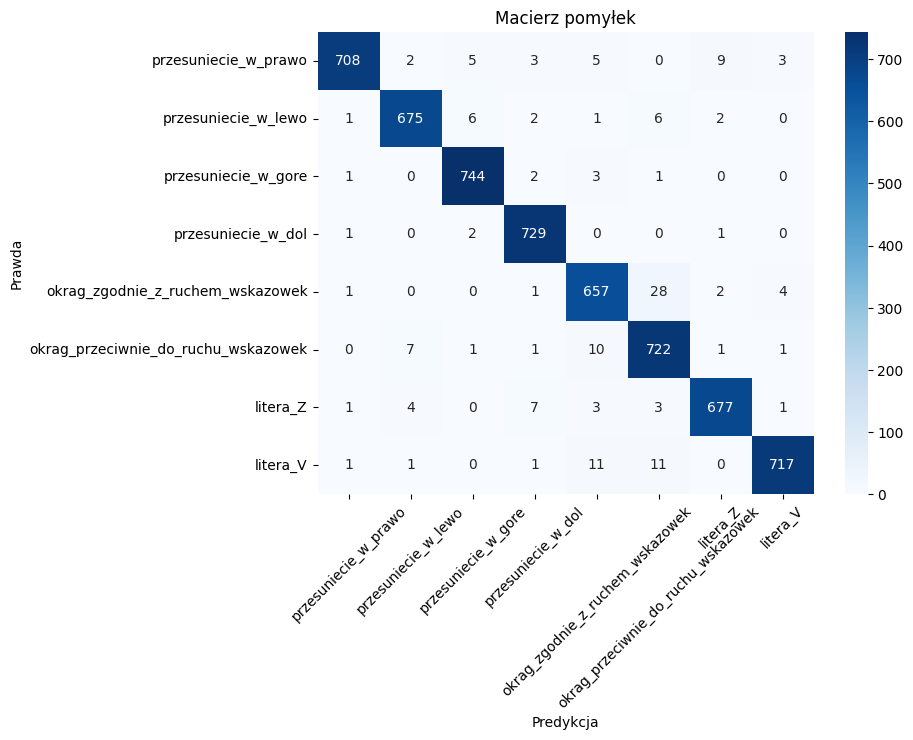

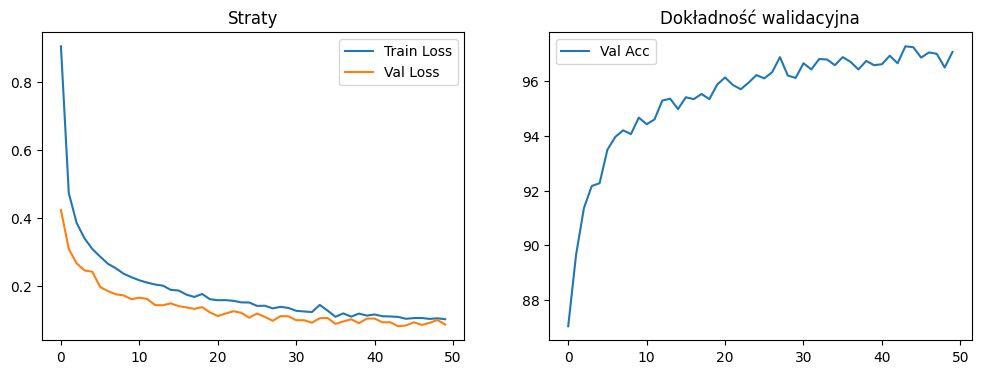

In [16]:
# 12. Wizualizacja: macierz pomyłek i historia trenowania
cm = confusion_matrix(all_trues, all_preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=GESTURES, yticklabels=GESTURES, cmap='Blues')
plt.xlabel('Predykcja'); plt.ylabel('Prawda'); plt.title('Macierz pomyłek')
plt.xticks(rotation=45); plt.yticks(rotation=0)
plt.show()

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'],   label='Val Loss')
plt.legend(); plt.title('Straty')
plt.subplot(1,2,2)
plt.plot(history['val_acc'], label='Val Acc')
plt.legend(); plt.title('Dokładność walidacyjna')
plt.show()


In [26]:
def export_model_to_onnx(model_path=None, output_path=None):
    """
    Eksportuje wytrenowany model CNN-LSTM do formatu ONNX

    Args:
        model_path: Ścieżka do zapisanego modelu (jeśli None, użyje aktualnie wytrenowanego)
        output_path: Ścieżka wyjściowa (domyślnie: gesture_model.onnx)

    Returns:
        Ścieżka do pliku ONNX lub None w przypadku błędu
    """
    import torch
    import os

    # Ustawienie domyślnej ścieżki wyjściowej
    if output_path is None:
        # output_path = "/content/drive/MyDrive/gesture_model.onnx"
        output_path = "/content/gesture_model.onnx"

    try:
        # Jeśli podano ścieżkę do modelu, załaduj go
        if model_path is not None:
            model_to_export = CNN_LSTM(in_channels=3, hidden_size=64, n_classes=len(GESTURES))
            model_to_export.load_state_dict(torch.load(model_path, map_location='cpu'))
            print(f"✅ Załadowano model z: {model_path}")
        else:
            # Użyj aktualnie wytrenowanego modelu
            model_to_export = model
            print("✅ Używam aktualnie wytrenowanego modelu")

        # KRYTYCZNE: Ustawienie w tryb inferencji
        model_to_export.eval()
        model_to_export = model_to_export.cpu()  # Przenieś na CPU

        # Utworzenie przykładowego wejścia
        # Dla CNN-LSTM: (batch_size, sequence_length, features)
        dummy_input = torch.randn(1, SEQUENCE_LENGTH, 3)

        print(f"🔧 Kształt wejścia: {dummy_input.shape}")
        print(f"📊 Parametry modelu:")
        print(f"   - Sequence length: {SEQUENCE_LENGTH}")
        print(f"   - Input channels: 3")
        print(f"   - Hidden size: 64")
        print(f"   - Number of classes: {len(GESTURES)}")
        print(f"   - Classes: {GESTURES}")

        # Test forward pass
        with torch.no_grad():
            test_output = model_to_export(dummy_input)
            print(f"✅ Test forward pass: {test_output.shape}")

        # Eksport do ONNX
        print(f"🚀 Rozpoczynam eksport do ONNX...")

        torch.onnx.export(
            model_to_export,                    # Model do eksportu
            dummy_input,                        # Przykładowe dane wejściowe
            output_path,                        # Ścieżka do pliku ONNX
            export_params=True,                 # Eksportuj wagi modelu
            opset_version=11,                   # Wersja ONNX (11 jest najbezpieczniejsza dla STM32)
            do_constant_folding=True,           # Optymalizacja stałych
            input_names=['accelerometer_data'], # Nazwa wejścia
            output_names=['gesture_prediction'], # Nazwa wyjścia
            dynamic_axes={                      # Dynamiczne osie (opcjonalne)
                'accelerometer_data': {0: 'batch_size'},
                'gesture_prediction': {0: 'batch_size'}
            },
            verbose=False                       # Szczegółowe logi
        )

        # Sprawdzenie rozmiaru pliku
        file_size = os.path.getsize(output_path) / 1024  # KB
        print(f"✅ Model wyeksportowany pomyślnie!")
        print(f"📁 Plik: {output_path}")
        print(f"📏 Rozmiar: {file_size:.2f} KB")

        # Zapisanie metadanych modelu
        metadata = {
            'sequence_length': SEQUENCE_LENGTH,
            'input_channels': 3,
            'hidden_size': 64,
            'num_classes': len(GESTURES),
            'gestures': GESTURES,
            'overlap_ratio': OVERLAP_RATIO
        }

        metadata_path = output_path.replace('.onnx', '_metadata.json')
        import json
        with open(metadata_path, 'w') as f:
            json.dump(metadata, f, indent=2)
        print(f"📋 Metadane zapisane: {metadata_path}")

        return output_path

    except Exception as e:
        print(f"❌ Błąd podczas eksportu: {e}")
        import traceback
        print(f"🔍 Szczegóły błędu:\n{traceback.format_exc()}")
        return None

# Funkcja weryfikacji eksportu
def verify_onnx_export(onnx_path):
    """
    Weryfikuje poprawność eksportu porównując wyniki PyTorch vs ONNX
    """
    try:
        import onnxruntime as ort
        import numpy as np

        print("🔍 Weryfikacja eksportu ONNX...")

        # Załaduj model ONNX
        ort_session = ort.InferenceSession(onnx_path)

        # Załaduj oryginalny model PyTorch
        model.eval()

        # Test na przykładowych danych
        test_input = torch.randn(1, SEQUENCE_LENGTH, 3)

        # PyTorch prediction
        with torch.no_grad():
            pytorch_output = model(test_input.cpu()).numpy()

        # ONNX prediction
        onnx_input = {ort_session.get_inputs()[0].name: test_input.numpy()}
        onnx_output = ort_session.run(None, onnx_input)[0]

        # Porównanie wyników
        max_diff = np.abs(pytorch_output - onnx_output).max()
        print(f"🔍 Maksymalna różnica między PyTorch a ONNX: {max_diff}")

        if max_diff < 1e-5:
            print("✅ Eksport zweryfikowany - modele są identyczne")
            return True
        else:
            print("⚠️ Wykryto różnice między modelami")
            print(f"PyTorch output: {pytorch_output}")
            print(f"ONNX output: {onnx_output}")
            return False

    except ImportError:
        print("💡 Zainstaluj onnxruntime aby zweryfikować eksport:")
        print("!pip install onnxruntime")
        return None
    except Exception as e:
        print(f"❌ Błąd weryfikacji: {e}")
        return False


In [24]:
!pip install onnx onnxruntime --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 111.3 MB/s eta 0:00:00


In [27]:
# Eksport najlepszego modelu do ONNX
print("=" * 60)
print("EKSPORT MODELU DO ONNX")
print("=" * 60)

# Opcja 1: Eksport aktualnie wytrenowanego modelu
# onnx_path = export_model_to_onnx()

# Opcja 2: Eksport z zapisanego pliku (jeśli chcesz użyć konkretnego pliku)
onnx_path = export_model_to_onnx('/content/best_model.pth')

if onnx_path:
    print("\n" + "=" * 60)
    print("WERYFIKACJA EKSPORTU")
    print("=" * 60)

    # Zainstaluj onnxruntime jeśli potrzeba
    try:
        import onnxruntime
    except ImportError:
        print("Instaluję onnxruntime...")
        !pip install onnxruntime

    # Weryfikuj eksport
    verify_onnx_export(onnx_path)

    print("\n" + "=" * 60)
    print("GOTOWE!")
    print("=" * 60)
    print(f"📁 Plik ONNX: {onnx_path}")
    print("🎯 Model gotowy do importu w X-CUBE-AI")


EKSPORT MODELU DO ONNX
✅ Załadowano model z: /content/best_model.pth
🔧 Kształt wejścia: torch.Size([1, 80, 3])
📊 Parametry modelu:
   - Sequence length: 80
   - Input channels: 3
   - Hidden size: 64
   - Number of classes: 8
   - Classes: ['przesuniecie_w_prawo', 'przesuniecie_w_lewo', 'przesuniecie_w_gore', 'przesuniecie_w_dol', 'okrag_zgodnie_z_ruchem_wskazowek', 'okrag_przeciwnie_do_ruchu_wskazowek', 'litera_Z', 'litera_V']
✅ Test forward pass: torch.Size([1, 8])
🚀 Rozpoczynam eksport do ONNX...
✅ Model wyeksportowany pomyślnie!
📁 Plik: /content/gesture_model.onnx
📏 Rozmiar: 167.81 KB
📋 Metadane zapisane: /content/gesture_model_metadata.json

WERYFIKACJA EKSPORTU
🔍 Weryfikacja eksportu ONNX...
❌ Błąd weryfikacji: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument weight in method wrapper_CUDA___slow_conv2d_forward)

GOTOWE!
📁 Plik ONNX: /content/gesture_model.onnx
🎯 Model gotowy do importu w X-CUBE-AI
